In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
import os
import statistics
from Bio import SeqIO
import matplotlib
from datetime import date
from datetime import datetime

In [4]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.font_manager

In [5]:
metaData=pd.read_csv('../../metadata/mabsc_all_sample_metadata.csv')

In [6]:
bol=[line.rstrip('\n') for line in open('../../metadata/samples_passing_depth_filters/bol_pass_depth.txt')]
mas=[line.rstrip('\n') for line in open('../../metadata/samples_passing_depth_filters/mas_pass_depth.txt')]
mab=[line.rstrip('\n') for line in open('../../metadata/samples_passing_depth_filters/mab_pass_depth.txt')]

In [7]:
# retrieve metadata from the table for all the biosamples that I want to look at
bol_meta=metaData[metaData['BioSample'].isin(bol)]
mas_meta=metaData[metaData['BioSample'].isin(mas)]
mab_meta=metaData[metaData['BioSample'].isin(mab)]

In [8]:
# Get list of patient IDs
bol_upid=list(set(bol_meta.patient_id))
mas_upid=list(set(mas_meta.patient_id))
mab_upid=list(set(mab_meta.patient_id))

In [9]:
# Get SNP distances for each subspecies
bol_dists=pd.read_csv('../snp_distance_matrices/bol_snp_dists.tsv', delimiter='\t')
mas_dists=pd.read_csv('../snp_distance_matrices/mas_snp_dists.tsv', delimiter='\t')
mab_dists=pd.read_csv('../snp_distance_matrices/mab_snp_dists.tsv', delimiter='\t')
bol_dists=bol_dists.set_index('snp-dists 0.7.0')
mas_dists=mas_dists.set_index('snp-dists 0.7.0')
mab_dists=mab_dists.set_index('snp-dists 0.7.0')

Get pairwise SNP distances for each patient:

In [14]:
def get_pairwise_snp_dists(upid_list, metadata, snp_dists):
    '''
    Input: 
        upid_list = list of patient identifiers
        metadata = metadata table MUST be subspecies-specific
        snp-dists = snp distance matrix
    Output: dictionary of pairwise snp dists
    
    '''
    pairwise_dist_dict={}
    
    for pid in upid_list: #loop through each patient id in my list of all the patients
        if type(pid) is str: #this just gets rid of the "NA"s
            
            
            #get metadata
            t=metadata[metadata['patient_id']==pid] #get all entries that match the patient id in this loop
            t=t.sort_values(by=['collection_year', 'collection_month', 'collection_day']) #sort by date
            t=t.drop_duplicates('Run') #Drop duplicate entries
            t=t.drop_duplicates('BioSample')
            
            t=t[t['BioSample'].isin(list(snp_dists.index))] #The reason this is here is that there are 
            # a couple of biosamples that I removed after I made the "biosample_pass_depth.txt" lists,
            # so they don't appear in my snp-distance matrix. Without this line python gets angry because
            # it looks for biosamples in the snp-distance matrix that aren't there.
            
            if len(t)>1: #I'm only interested in patients who have multiple different isolates
                biosamples=list(t.BioSample)
                dists=snp_dists.loc[biosamples,biosamples]
                pairwise_dists=list(dists.values[np.triu_indices(dists.shape[0], k=1)])
                
                pairwise_dist_dict[pid]=pairwise_dists
                
    return(pairwise_dist_dict)

In [15]:
# Get dictionaries of the pairwise snp distances for each patient
mab_pairwise=get_pairwise_snp_dists(mab_upid, mab_meta, mab_dists)
mas_pairwise=get_pairwise_snp_dists(mas_upid, mas_meta, mas_dists)
bol_pairwise=get_pairwise_snp_dists(bol_upid, bol_meta, bol_dists)

In [16]:
# get lists of all pairwise snp distances in each subsp
mab_all_pairwise_dists=[j for i in mab_pairwise.values() for j in i]
mas_all_pairwise_dists=[j for i in mas_pairwise.values() for j in i]
bol_all_pairwise_dists=[j for i in bol_pairwise.values() for j in i]

### Look at SNP distributions:

#### MAB:

Text(0.5, 1.0, 'MAB pairwise SNP distances')

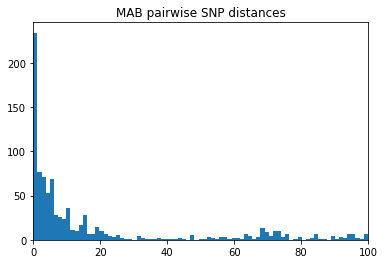

In [17]:
plt.hist(mab_all_pairwise_dists, bins=10000)
plt.xlim(0,100)
plt.title('MAB pairwise SNP distances')

In [18]:
# what percentage of isolate pairs are =< 20 snps?
len([i for i in mab_all_pairwise_dists if i <21])/len(mab_all_pairwise_dists)

0.5128022759601707

#### MAS:

Text(0.5, 1.0, 'MAS pairwise SNP distances')

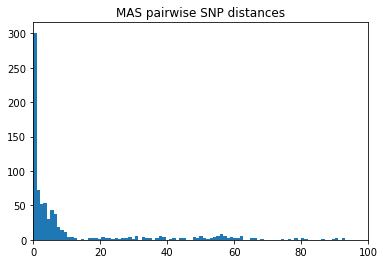

In [19]:
# Now look at the distribution for MAS:
plt.hist(mas_all_pairwise_dists, bins=10000)
plt.xlim(0,100)
plt.title('MAS pairwise SNP distances')

In [20]:
len([i for i in mas_all_pairwise_dists if i <21])/len(mas_all_pairwise_dists)

0.7673325499412456

In [21]:
len([i for i in bol_all_pairwise_dists if i <21])/len(bol_all_pairwise_dists)

0.961038961038961

# Estimate a rate for MAB

I want to choose a SNP distance threshold that is lower than the median pairwise snp distance within the clusters. To calculate this:

In [22]:
clusterA_samples=[line.rstrip('\n') for line in open('../../metadata/clusters/mab_clusterA.txt')]
clusterA_dists=mab_dists.loc[clusterA_samples][clusterA_samples]
cA_pairwise_dists=list(clusterA_dists.values[np.triu_indices(clusterA_dists.shape[0], k=1)])
statistics.median(cA_pairwise_dists)

68

In [23]:
clusterB_samples=[line.rstrip('\n') for line in open('../../metadata/clusters/mab_clusterB.txt')]
clusterB_dists=mab_dists.loc[clusterB_samples][clusterB_samples]
cB_pairwise_dists=list(clusterB_dists.values[np.triu_indices(clusterB_dists.shape[0], k=1)])
statistics.median(cB_pairwise_dists)

53

In [24]:
clusterC_samples=[line.rstrip('\n') for line in open('../../metadata/clusters/mab_clusterC.txt')]
clusterC_dists=mab_dists.loc[clusterC_samples][clusterC_samples]
cC_pairwise_dists=list(clusterC_dists.values[np.triu_indices(clusterC_dists.shape[0], k=1)])
statistics.median(cC_pairwise_dists)

66

Overlay cluster isolates with within-patient isolates:

In [25]:
mab_all_pairwise_dists_filtered=[i for i in mab_all_pairwise_dists if i <200]

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


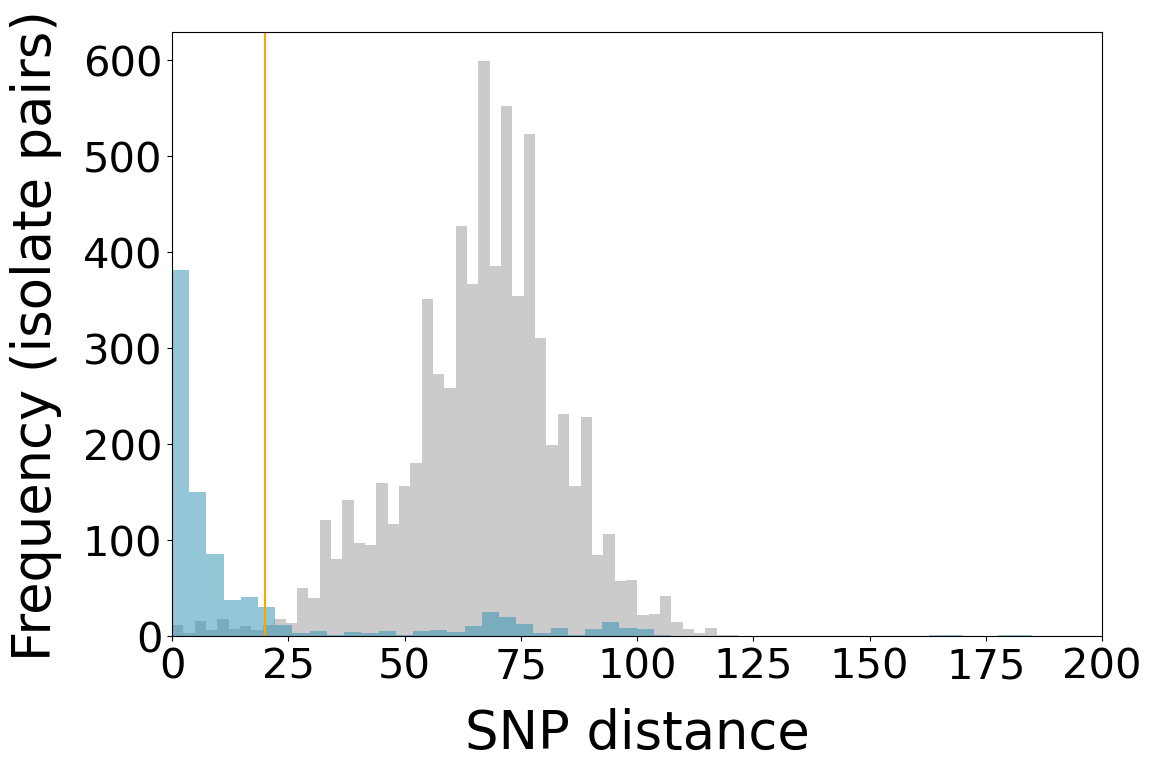

In [26]:
# Cluster A
plt.figure(figsize=(12, 8), dpi=100)
plt.hist(cA_pairwise_dists, bins=50, alpha=.5, color='#999999')
plt.hist(mab_all_pairwise_dists_filtered, bins=50, alpha=.5, color='#298FAF')
plt.xlim(0,200)
plt.axvline(20, color='orange')
plt.xlabel("SNP distance", fontsize=38, fontname="Arial", labelpad=15)
plt.ylabel("Frequency (isolate pairs)", fontsize=38, fontname="Arial", labelpad=15)
plt.xticks(fontsize=30, fontname="Arial")
plt.yticks(fontsize=30, fontname="Arial")
# plt.text(90, 275, 'Within-host isolate pairs', fontsize=28, color='g')
# plt.text(90, 250, 'MAB cluster 2', fontsize=28, color='b', alpha=0.5)

(array([  0.,  50., 100., 150., 200., 250.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

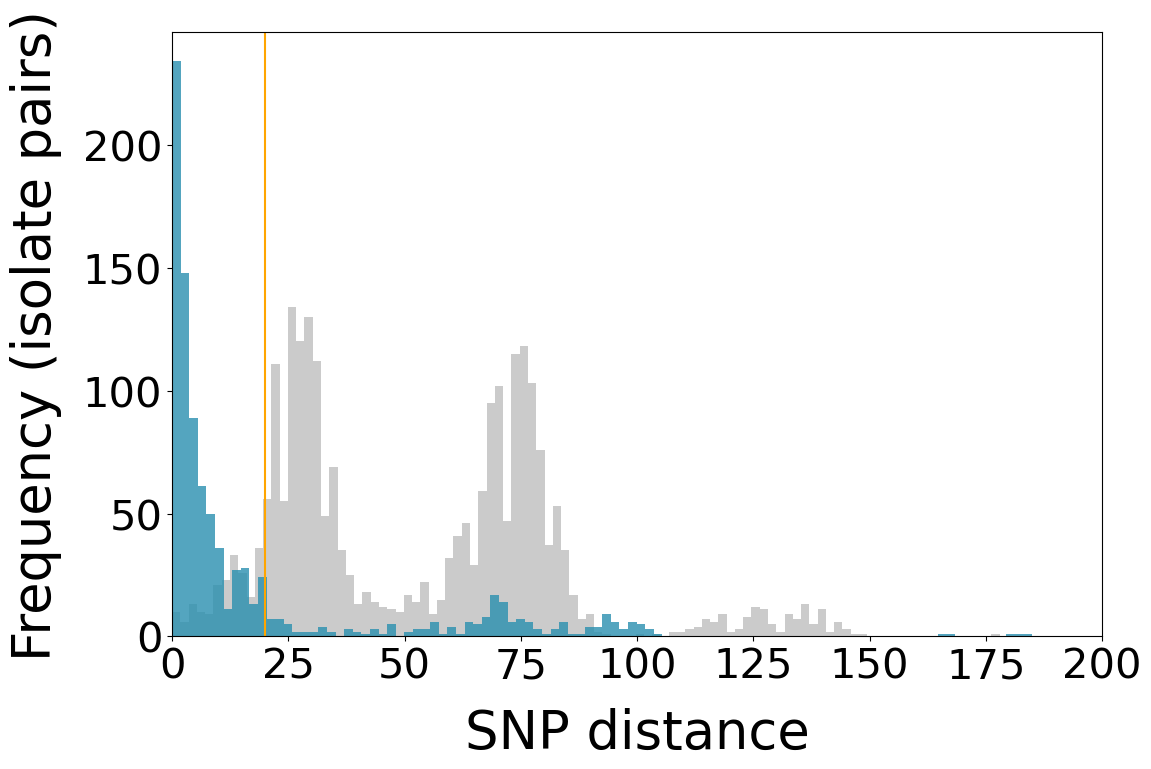

In [27]:
# Cluster B
plt.figure(figsize=(12, 8), dpi=100)
plt.hist(cB_pairwise_dists, bins=100, alpha=.5, color='#999999')
plt.hist(mab_all_pairwise_dists_filtered, bins=100, alpha=.8, color='#298FAF')
plt.xlim(0,200)
plt.axvline(20, color='orange')
plt.xlabel("SNP distance", fontsize=38, fontname="Arial", labelpad=15)
plt.ylabel("Frequency (isolate pairs)", fontsize=38, fontname="Arial", labelpad=15)
plt.xticks(fontsize=30, fontname="Arial")
plt.yticks(fontsize=30, fontname="Arial")
# plt.text(90, 275, 'Within-host isolate pairs', fontsize=28, color='g')
# plt.text(90, 250, 'MAB cluster 1', fontsize=28, color='b', alpha=0.5)

(array([  0.,  50., 100., 150., 200., 250.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

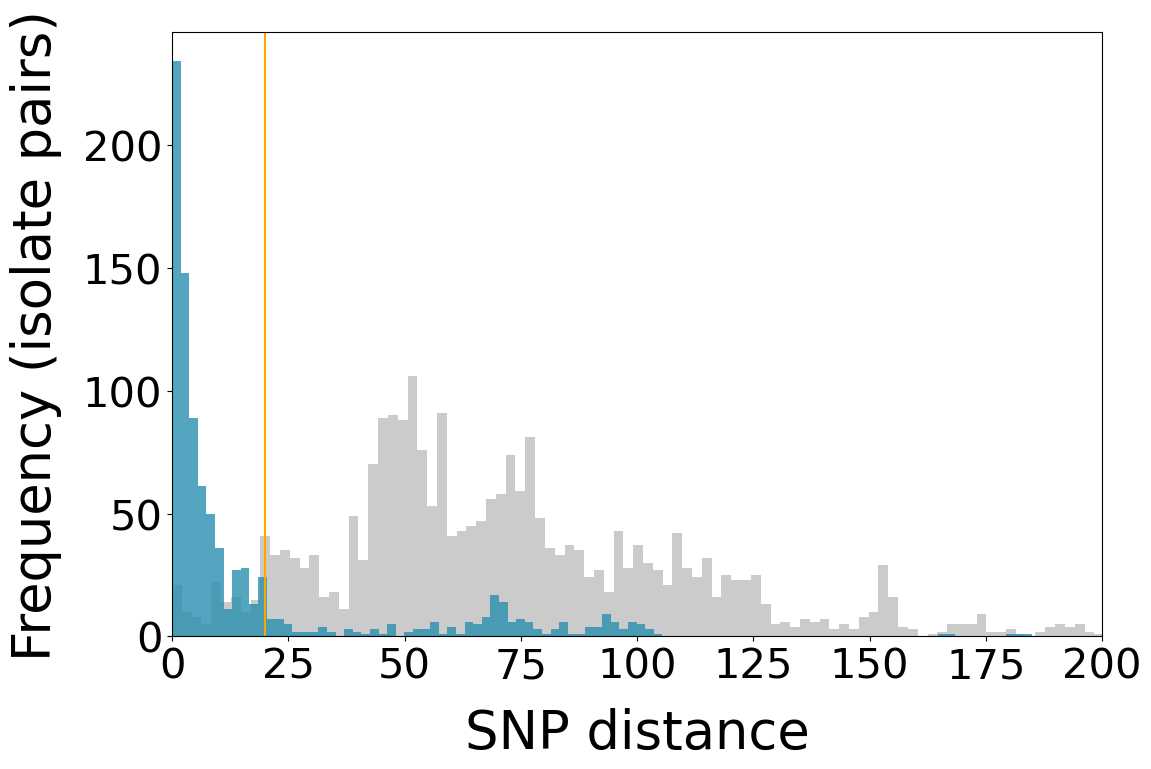

In [28]:
# Cluster C
plt.figure(figsize=(12, 8), dpi=100)
plt.hist(cC_pairwise_dists, bins=100, alpha=.5, color='#999999')
plt.hist(mab_all_pairwise_dists_filtered, bins=100, alpha=.8, color='#298FAF')
plt.xlim(0,200)
plt.axvline(20, color='orange')
plt.xlabel("SNP distance", fontsize=38, fontname="Arial", labelpad=15)
plt.ylabel("Frequency (isolate pairs)", fontsize=38, fontname="Arial", labelpad=15)
plt.xticks(fontsize=30, fontname="Arial")
plt.yticks(fontsize=30, fontname="Arial")
# plt.text(90, 275, 'Within-host isolate pairs', fontsize=28, color='g')
# plt.text(90, 250, 'MAB cluster 1', fontsize=28, color='b', alpha=0.5)

#### Let's settle on 20 for a good SNP distance threshold for MAB. Now let's do the regression analysis:

In [29]:
# This is a function that I wrote to aggregate metadata, snp distances for each patient
def get_dists_from_first_iso(upid_list, metadata, snp_dists, outdir):
    '''
    Input: 
        upid_list = list of patient identifiers
        metadata = metadata table MUST be subspecies-specific
        snp-dists = snp distance matrix
        outdir
    Output:
        For each patient, will output a csv containing relevant metadata, dates, and snp-distances
    '''
    for pid in upid_list: #loop through each patient id in my list of all the patients
        if type(pid) is str: #this just gets rid of the "NA"s
            
            
            #get metadata
            t=metadata[metadata['patient_id']==pid] #get all entries that match the patient id in this loop
            t=t.sort_values(by=['collection_year', 'collection_month', 'collection_day']) #sort by date
            t=t.drop_duplicates('Run') #Drop duplicate entries
            t=t.drop_duplicates('BioSample')
            
            t=t[t['BioSample'].isin(list(snp_dists.index))] #The reason this is here is that there are 
            # a couple of biosamples that I removed after I made the "biosample_pass_depth.txt" lists,
            # so they don't appear in my snp-distance matrix. Without this line python gets angry because
            # it looks for biosamples in the snp-distance matrix that aren't there.
            
            if len(t)>1: #I'm only interested in patients who have multiple different isolates
                
                # get all the fields I'm interested in
                meta=t[['BioSample', 'collection_year', 'collection_month', 'collection_day', 'BioProject']].reset_index()
                meta=meta.fillna(1) #fill in missing date information with 1 (if there is no month, we assume January)

                #get the date of the first entry
                year0=int(meta.iloc[0]['collection_year'])
                month0=int(meta.iloc[0]['collection_month'])
                day0=int(meta.iloc[0]['collection_day'])
                date0=datetime(year0, month0, day0) 
                
                for i in range(1, len(meta)): #python indexes from 0 so 1 is the second entry in the table
                                    
                    #get the date of the current entry
                    year=int(meta.iloc[i]['collection_year'])
                    month=int(meta.iloc[i]['collection_month'])
                    day=int(meta.iloc[i]['collection_day'])
                    date=datetime(year, month, day)
                    
                    #get the delta time and write it to the metadata table:
                    delta=date-date0
                    meta.loc[i, 'days_from_first_isolate']=delta.days
                    
                    #get snp distances
                    biosample0=meta.loc[0, 'BioSample']
                    biosample=meta.loc[i, 'BioSample']
                    dist=snp_dists[biosample0][biosample]
                    meta.loc[i, 'snp_dist_from_first_isolate']=dist
                    
                    #add patient id (will be useful later)
                    meta.loc[i, 'patient_id']=pid
                
                #write metadata info to csv
                meta.to_csv(outdir+'/'+pid+'.csv', index=False)

In [30]:
!mkdir longitudinal_isolates_dist_from_first_iso

mkdir: cannot create directory ‘longitudinal_isolates_dist_from_first_iso’: File exists


In [31]:
get_dists_from_first_iso(mab_upid, mab_meta, mab_dists, 'longitudinal_isolates_dist_from_first_iso')

In [32]:
mab_frames=[pd.read_csv('longitudinal_isolates_dist_from_first_iso/'+f) for f in os.listdir('longitudinal_isolates_dist_from_first_iso')]

In [33]:
# Now lets drop everything wehre there aren't true longitudinal data:
mab_frames_filtered=[frame[frame.days_from_first_isolate!=0] for frame in mab_frames]

In [34]:
# Now drop all the frames that no longer have more than one entry:
mab_frames_filtered2=[frame for frame in mab_frames_filtered if len(frame)>1]

In [35]:
# Get the number of patients with longitudinal MAB isolates:
len(mab_frames_filtered2)

88

In [36]:
# Now let's drop everything with <21 snp distance
mab_frames_clonal=[frame[(frame.snp_dist_from_first_isolate<21) | (frame.snp_dist_from_first_isolate.isnull())] for frame in mab_frames_filtered2]
mab_frames_clonal=[frame for frame in mab_frames_clonal if len(frame)>1] # only keep isolates where we still have more than the first isolate after removing everything > 20 SNPs away
mab_frames_clonal=[frame.iloc[-1] for frame in mab_frames_clonal]

In [37]:
len(mab_frames_clonal)

47

In [38]:
mab_scatter=pd.DataFrame(mab_frames_clonal)
mab_scatter.head()

,index,BioSample,collection_year,collection_month,collection_day,BioProject,days_from_first_isolate,snp_dist_from_first_isolate,patient_id
3,952,SAMEA2259660,2006,1.0,1.0,PRJEB2779,731.0,8.0,PRJEB2779_B_AP
1,150,SAMEA2068670,2004,1.0,1.0,PRJEB2779,1095.0,10.0,PRJEB2779_Q_U
15,1327,SAMEA5396759,2015,11.0,29.0,PRJEB31559,180.0,1.0,PRJEB31559_ldn_gos_41
1,912,SAMEA2259620,2011,1.0,1.0,PRJEB2779,365.0,0.0,PRJEB2779_B_Y
2,841,SAMEA2259547,2004,1.0,1.0,PRJEB2779,365.0,2.0,PRJEB2779_B_A


In [39]:
mab_scatter['years_from_first_isolate']=mab_scatter['days_from_first_isolate']/365

In [40]:
X = mab_scatter['years_from_first_isolate'].values.reshape(-1,1)
y = mab_scatter['snp_dist_from_first_isolate'].values.reshape(-1,1)
reg = LinearRegression()
reg.fit(X, y)
print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))

The linear model is: Y = 3.3936 + 0.75342X


In [41]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     3.384
Date:                Mon, 25 Apr 2022   Prob (F-statistic):             0.0724
Time:                        21:06:18   Log-Likelihood:                -139.95
No. Observations:                  47   AIC:                             283.9
Df Residuals:                      45   BIC:                             287.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3936      1.089      3.116      0.0

In [42]:
est2.pvalues

array([0.00318805, 0.07244589])

(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

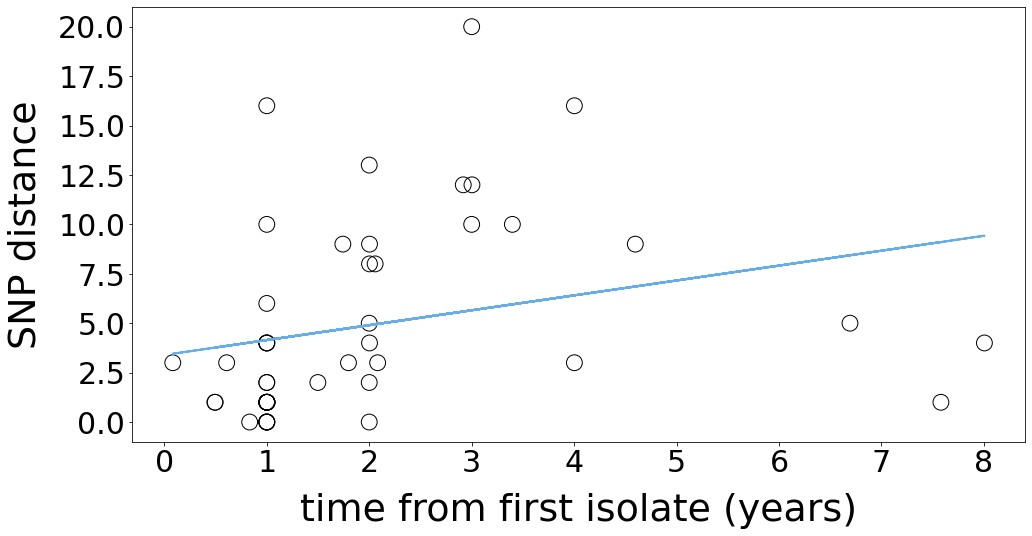

In [43]:
predictions = reg.predict(X)
plt.figure(figsize=(16, 8))
plt.scatter(
    X,
    y,
    facecolors='none',
    edgecolors='black',
    s=250
)
plt.plot(
    X,
    predictions,
    c='#66AEE7', 
    linewidth=2,
)
plt.xlabel("time from first isolate (years)", fontsize=38, fontname="Arial", labelpad=15)
plt.ylabel("SNP distance", fontsize=38, fontname="Arial", labelpad=15)
plt.xticks(fontsize=30, fontname="Arial")
plt.yticks(fontsize=30, fontname="Arial")

#### Let's drop samples that have a high % of variation attributable to recombination:

In [51]:
mab_recomb_data=pd.read_csv('MAB_recombination_data.csv', sep='\t') # calculated from Gubbins output
low_recomb=list(mab_recomb_data[mab_recomb_data['recombination(N)']<=20].BioSample)

In [52]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     15.21
Date:                Mon, 25 Apr 2022   Prob (F-statistic):           0.000463
Time:                        21:22:49   Log-Likelihood:                -92.924
No. Observations:                  34   AIC:                             189.8
Df Residuals:                      32   BIC:                             192.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0623      1.186      0.896      0.3

In [53]:
est2.pvalues

array([0.37716346, 0.00046302])

In [54]:
# Estimate mutation rate per site:
2.2/(5000000*0.85)

5.176470588235294e-07

In [56]:
# Estimate confidence intervals: 
1.056/(5000000*0.85)

2.484705882352941e-07

In [57]:
3.365/(5000000*0.85)

7.91764705882353e-07

The linear model is: Y = 1.0623 + 2.2104X


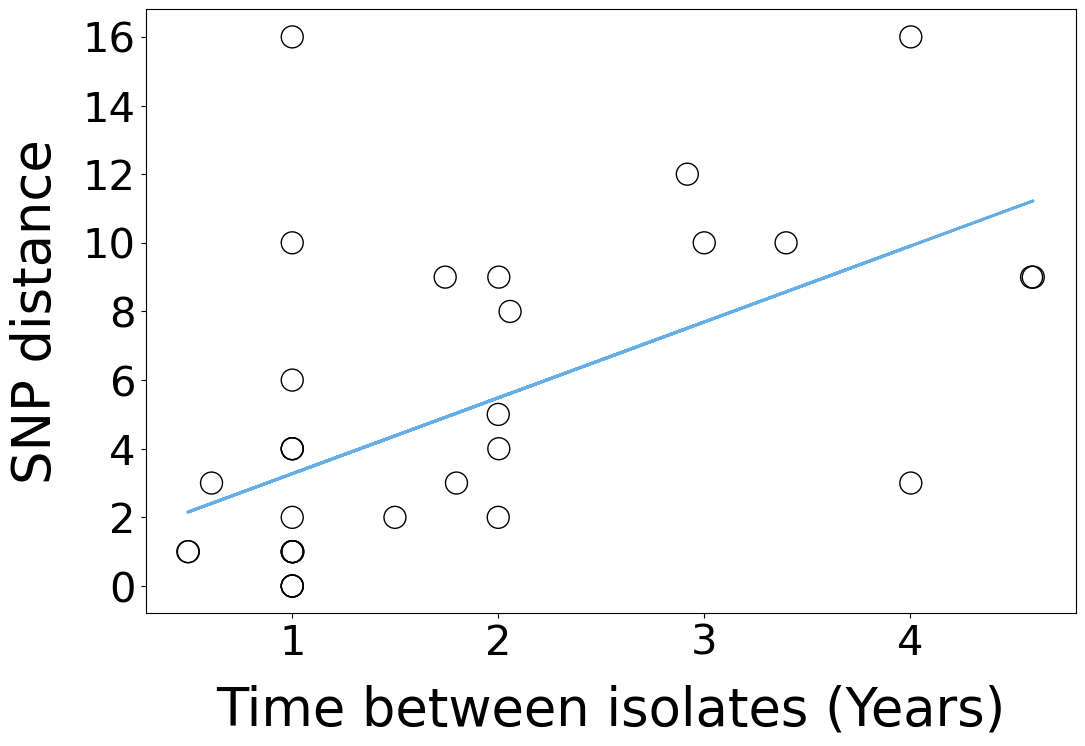

In [55]:
mab_frames=[pd.read_csv('/n/data1/hms/dbmi/farhat/nikki/abscessus/0_NOTEBOOKS/004_LONGITUDINAL_ISOLATES/20210527_longitudinal_isolate_pairs/MAB/'+f) for f in os.listdir('/n/data1/hms/dbmi/farhat/nikki/abscessus/0_NOTEBOOKS/004_LONGITUDINAL_ISOLATES/20210527_longitudinal_isolate_pairs/MAB/')]
#mab_frames=[pd.read_csv('20210601_longitudinal_isolates_dist_from_previous_iso/MAB/'+f) for f in os.listdir('20210601_longitudinal_isolates_dist_from_first_iso/MAB/')]
mab_cat = pd.concat(mab_frames)
mab_scatter=mab_cat[mab_cat['days_from_first_isolate']>0]

mab_scatter=mab_scatter[mab_scatter.BioSample.isin(low_recomb)]

mab_scatter['years_from_first_isolate']=mab_scatter['days_from_first_isolate']/365
#mab_scatter['snp_expectation']=mab_scatter['years_from_first_isolate']*15.3
mab_scatter['snp_expectation']=mab_scatter['years_from_first_isolate']*50
mab_scatter_filtered=mab_scatter[mab_scatter['snp_dist_from_first_isolate']<mab_scatter['snp_expectation']]
mab_scatter_filtered=mab_scatter[mab_scatter['snp_dist_from_first_isolate']<21]

X = mab_scatter_filtered['years_from_first_isolate'].values.reshape(-1,1)
y = mab_scatter_filtered['snp_dist_from_first_isolate'].values.reshape(-1,1)
reg = LinearRegression()
reg.fit(X, y)
print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))

predictions = reg.predict(X)
plt.figure(figsize=(12, 8), dpi=100)
plt.scatter(
    X,
    y,
    facecolors='none',
    edgecolors='black',
    s=250
)
plt.plot(
    X,
    predictions,
    c='#66AEE7', 
    linewidth=2,
)
plt.xlabel("Time between isolates (Years)", fontsize=38, fontname="Arial", labelpad=15)
plt.ylabel("SNP distance", fontsize=38, fontname="Arial", labelpad=15)
plt.xticks(fontsize=30, fontname="Arial")
plt.yticks(fontsize=30, fontname="Arial")
# plt.text(1.2, 15, r'$slope=$2.21', fontsize=34)
# plt.text(1.2, 13.5, r'$R^2=$0.32', fontsize=34)
# plt.text(1.2, 12, r'$p=0.0005$', fontsize=34)
# plt.text(.5, 80, r'$slope=$4.68', fontsize=34)
# plt.text(.5, 73, r'$R^2=$0.34', fontsize=34)
# plt.text(.5, 67, r'$p=0.00$', fontsize=34)
plt.savefig('within_host_regression.pdf', format='pdf', bbox_inches = "tight", dpi=300)